# 3DMNN
#### EXPERIMENTS

In [1]:
import os.path as osp
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/viktorv/Projects/3DMNN/main/models/latent_space/src")

from classes.autoencoder import Configuration as Conf
from classes.gan import ConfigurationGAN as ConfGAN
from classes.pointnet_ae import PointNetAutoEncoder

from utils.templates import innofair_architecture
from utils.templates import autoencoder_paper, default_train_params
from utils.io import obj_wrapper

from utils.io import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from utils.utils import reset_tf_graph
from classes.latent_gan import LatentGAN
from utils.plyfile import PlyData, PlyElement

top_out_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data'          # Use to save Neural-Net check-points etc.
top_in_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

class_name = "airplane"

syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir, syn_id)

all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

# train_params = default_train_params()

# encoder, decoder, enc_args, dec_args = autoencoder_paper(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

# conf = Conf(
#     n_input = [n_pc_points, 3],
#     loss = ae_loss,
#     training_epochs = 50,
#     batch_size = train_params['batch_size'],
#     denoising = train_params['denoising'],
#     learning_rate = train_params['learning_rate'],
#     train_dir = train_dir,
#     loss_display_step = train_params['loss_display_step'],
#     saver_step = train_params['saver_step'],
#     z_rotate = train_params['z_rotate'],
#     encoder = encoder,
#     decoder = decoder,
#     encoder_args = enc_args,
#     decoder_args = dec_args
# )
# conf.experiment_name = experiment_name
# conf.held_out_step = 5   # How often to evaluate/print out loss on 
#                          # held_out data (if they are provided in ae.train() ).
# conf.save(osp.join(train_dir, 'configuration'))


# ae = PointNetAutoEncoder(conf.experiment_name, conf)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

conf = Conf.load(train_dir + "/configuration")
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False

reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
ae.restore_model(conf.train_dir, 50, verbose=True)


<generator object files_in_subdirs at 0x7f855c3601a8>
4045 pclouds were loaded. They belong in 1 shape-classes.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/single_class_ae/models.ckpt-50
Model restored in epoch 50.


Trained a simple point net auto encoder... Define reconstruct and interpolate functions

In [2]:
#reconstructions = np.asarray(ae.reconstruct(feed_pc))
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)

def reconstruct_obj(reconstructions):
    print("Reconstruction item shape:", reconstructions[0].shape)
    
    for i, reconstruction in enumerate(reconstructions):
        obj_wrapper(reconstruction, class_name, i)
        
    print("Reconstructed")

def interpolate(_from, _to, steps=10):
    
    print("Generating interpolations")
    interpolations = ae.interpolate(reconstructions[0][_from], reconstructions[0][_to], steps)

    for i, interpolation in enumerate(interpolations):
        obj_wrapper(interpolation, class_name + "_intr", i)

    print("Interpolation Complete")
    print(interpolations.shape)

Create and Configure GAN...

In [3]:
generator, discriminator, params = innofair_architecture(128)

print(latent_codes.shape)
print(params)
# TODO:
# 5. Implement Conditional GAN in the LGAN

reset_tf_graph()
gan = LatentGAN(experiment_name, params['init_lr'], params['lambda'], params['n_out'],\
                params['noise_dim'], discriminator, generator, beta=params['beta'])


(4045, 128)
{'init_lr': 0.0001, 'lambda': 10, 'n_out': [128], 'noise_dim': 128, 'beta': 0.5, 'batch_size': 50, 'noise_params': {'mu': 0, 'sigma': 0.2}}
Calculating initial GP...


1 (-10.777133282274008, -1.3488493933691643)
INFO:tensorflow:./models_checkpoints/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (-20.667162585258485, -4.674676641821861)
3 (-20.07437026500702, -5.6529815793037415)
4 (-19.097456955909728, -6.293584406375885)
5 (-18.05333204269409, -6.950708389282227)
INFO:tensorflow:./models_checkpoints/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.
6 (-16.949535131454468, -7.547347217798233)
7 (-15.81203272342682, -8.112374693155289)
8 (-14.651004338264466, -8.615529358386993)
9 (-13.522150540351868, -8.942264676094055)
10 (-12.431158721446991, -9.154445350170135)
INFO:tensorflow:./models_checkpoints/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


/home/viktorv/.conda/envs/3dmnn_cu9/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


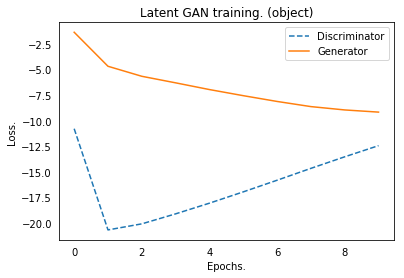

In [4]:
accum_syn_data = []
train_stats = []
n_epochs = 10
# Train the GAN.
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])
latent_data = PointCloudDataSet(latent_codes)

gan.train(latent_data, params, n_epochs, "./models_checkpoints/", save_gan_model=True, \
          saver_step=saver_step, train_stats=train_stats)

In [5]:
syn_latent_data = gan.generate(5, params["noise_params"])
syn_data = ae.decode(syn_latent_data)
print(syn_data.shape)
elements = []
data = []

for i, e in enumerate(syn_data):
    pc = e.reshape(2048*3)
    pc_ply = PlyElement.describe(pc, "generated_%s" % i)
    PlyData([pc_ply], byte_order="<").write("binTest%s.ply"%i)

(5, 2048, 3)


AttributeError: 'tuple' object has no attribute 'pop'

# TODO
### 1. Rewrite CONF Class to fit GANs - DONE
### 2. Implement Discriminator, Generator for the simple LGAN - DONE
### 3. Train
### 4. Try to decode something generated
### 5. Implement Conditional GAN in the LGAN 
### 6. Go to 3 and 4 again